# Class Demo — FP-Growth for Frequent Itemset Mining (Association Analysis)

**Goal:** Mine **frequent itemsets** from transaction (market-basket) data using **FP-Growth**.

FP-Growth is a classic alternative to Apriori that avoids explicit **candidate generation** by:
- compressing transactions into an **FP-tree**, and  
- mining patterns via **pattern growth**.

---

## Learning goals (for today)
By the end of this demo, you will be able to:
1. Convert transaction data into a one-hot encoded format suitable for frequent pattern mining.
2. Run **FP-Growth** to find frequent itemsets at a chosen minimum support threshold.
3. Interpret frequent itemset output and understand the effect of changing **min_support**.


## 0) Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If you are running this in a fresh environment (e.g., Colab), uncomment:
# !pip -q install mlxtend

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth


## 1) Transaction Data (Toy Market-Basket Dataset)

Each transaction is a basket of items.  
This dataset is intentionally small so you can verify results by inspection.


In [4]:
transactions = [
    ["milk", "bread", "eggs"],
    ["milk", "bread"],
    ["milk", "diapers", "beer", "bread"],
    ["bread", "butter"],
    ["milk", "bread", "butter"],
    ["diapers", "beer"],
    ["milk", "diapers", "bread", "butter"],
    ["bread", "eggs"],
    ["milk", "eggs"],
    ["milk", "bread", "diapers", "beer"],
]

print("Number of transactions:", len(transactions))
transactions[:3]


Number of transactions: 10


[['milk', 'bread', 'eggs'],
 ['milk', 'bread'],
 ['milk', 'diapers', 'beer', 'bread']]

### 1.1) (Optional) View transactions as a table


In [5]:
tx_df = pd.DataFrame({"TID": [f"T{i+1:02d}" for i in range(len(transactions))],
                      "items": [", ".join(t) for t in transactions]})
tx_df


,TID,items
0,T01,"milk, bread, eggs"
1,T02,"milk, bread"
2,T03,"milk, diapers, beer, bread"
3,T04,"bread, butter"
4,T05,"milk, bread, butter"
5,T06,"diapers, beer"
6,T07,"milk, diapers, bread, butter"
7,T08,"bread, eggs"
8,T09,"milk, eggs"
9,T10,"milk, bread, diapers, beer"


## 2) One-Hot Encoding

FP-Growth in `mlxtend` expects a boolean dataframe:
- Rows = transactions  
- Columns = items  
- Values = True/False indicating whether the item appears in the transaction


In [6]:
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
basket = pd.DataFrame(te_array, columns=te.columns_)

basket.head()


,beer,bread,butter,diapers,eggs,milk
0,False,True,False,False,True,True
1,False,True,False,False,False,True
2,True,True,False,True,False,True
3,False,True,True,False,False,False
4,False,True,True,False,False,True


### 2.1) Item frequency (1-item supports)

- **count** = how many transactions contain the item  
- **support** = count / number_of_transactions


In [7]:
item_counts = basket.sum().sort_values(ascending=False)
item_support = (basket.mean()).sort_values(ascending=False)

pd.DataFrame({"count": item_counts, "support": item_support})


,count,support
bread,8,0.8
milk,7,0.7
diapers,4,0.4
beer,3,0.3
butter,3,0.3
eggs,3,0.3


## 3) FP-Growth: Frequent Itemsets

### 3.1) Choose a minimum support

`min_support` is a fraction in [0,1].  
Example: `min_support = 0.30` means the itemset must appear in at least **30%** of transactions.

With 10 transactions, support 0.30 corresponds to appearing in ≥ 3 transactions.


In [8]:
min_support = 0.30
min_count = int(np.ceil(min_support * len(transactions)))
print(f"min_support = {min_support:.2f}  ->  min_count = {min_count} transactions")


min_support = 0.30  ->  min_count = 3 transactions


### 3.2) Run FP-Growth


In [9]:
freq_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)
freq_itemsets = freq_itemsets.sort_values(["support", "itemsets"], ascending=[False, True]).reset_index(drop=True)
freq_itemsets


,support,itemsets
0,0.8,(bread)
1,0.7,(milk)
2,0.6,"(milk, bread)"
3,0.4,(diapers)
4,0.3,(eggs)
5,0.3,(beer)
6,0.3,(butter)
7,0.3,"(diapers, milk)"
8,0.3,"(diapers, bread)"
9,0.3,"(diapers, bread, milk)"


### 3.3) Display itemsets in a readable form


In [10]:
freq_itemsets_display = freq_itemsets.copy()
freq_itemsets_display["itemsets"] = freq_itemsets_display["itemsets"].apply(lambda s: ", ".join(sorted(list(s))))
freq_itemsets_display


,support,itemsets
0,0.8,bread
1,0.7,milk
2,0.6,"bread, milk"
3,0.4,diapers
4,0.3,eggs
5,0.3,beer
6,0.3,butter
7,0.3,"diapers, milk"
8,0.3,"bread, diapers"
9,0.3,"bread, diapers, milk"


## 4) Interpreting the Output

**How to read this table**
- `itemsets` = the set of items that co-occur
- `support` = fraction of baskets that contain *all* items in the itemset

**Rule of thumb**
- Higher support → more common pattern  
- Lower min_support → more patterns (often much more in real datasets)


## 5) Sensitivity Study: What happens when we change `min_support`?

In real data, the number of frequent itemsets can grow quickly as support decreases.
We will compute how many itemsets FP-Growth returns for a range of thresholds.


In [11]:
thresholds = [0.50, 0.40, 0.30, 0.20, 0.10]

rows = []
for th in thresholds:
    fi = fpgrowth(basket, min_support=th, use_colnames=True)
    rows.append({
        "min_support": th,
        "min_count": int(np.ceil(th * len(transactions))),
        "num_itemsets": len(fi),
        "max_k": int(max((len(s) for s in fi["itemsets"]), default=0))
    })

summary = pd.DataFrame(rows).sort_values("min_support", ascending=False).reset_index(drop=True)
summary


,min_support,min_count,num_itemsets,max_k
0,0.5,5,3,2
1,0.4,4,4,2
2,0.3,3,12,3
3,0.2,2,22,4
4,0.1,1,27,4


### 5.1) Plot: number of frequent itemsets vs. support threshold


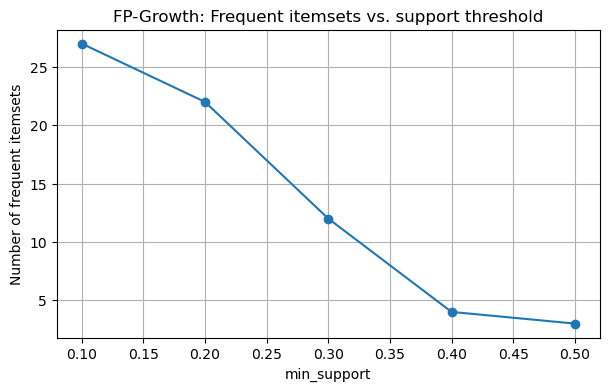

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(summary["min_support"], summary["num_itemsets"], marker="o")
plt.xlabel("min_support")
plt.ylabel("Number of frequent itemsets")
plt.title("FP-Growth: Frequent itemsets vs. support threshold")
plt.grid(True)
plt.show()


## 6) Show the Top Patterns (by support)

This is useful when presenting results in class.


In [13]:
top_k = 10

top_patterns = freq_itemsets_display.head(top_k).copy()
top_patterns.insert(0, "rank", range(1, len(top_patterns) + 1))
top_patterns


,rank,support,itemsets
0,1,0.8,bread
1,2,0.7,milk
2,3,0.6,"bread, milk"
3,4,0.4,diapers
4,5,0.3,eggs
5,6,0.3,beer
6,7,0.3,butter
7,8,0.3,"diapers, milk"
8,9,0.3,"bread, diapers"
9,10,0.3,"bread, diapers, milk"


## 7) In-Class Discussion Prompts

1. Which item(s) are most frequent individually?  
2. Which 2-item combinations have the highest support?  
3. What do you expect to happen to runtime and output size if we reduce `min_support` further on a large dataset?

# See you next lecture!